# Amazon Apparel Recommendations using TF_IDF_W2V and Convolutional Neural Network

## [1] Data and Code:
https://drive.google.com/open?id=0BwNkduBnePt2VWhCYXhMV3p4dTg



### [1.1] Overview of the data

In [1]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [0]:
# we have give a json file which consists of all information about
# the products
# loading the data using pandas' read_json file.
data = pd.read_json('tops_fashion.json')


In [0]:
print ('Number of data points : ', data.shape[0], \
       'Number of features/variables:', data.shape[1])

Number of data points :  183138 Number of features/variables: 19


### Terminology:
What is a dataset? <br>
Rows and columns <br>
Data-point <br>
Feature/variable <br>







In [0]:
# each product/item has 19 features in the raw dataset.
data.columns # prints column-names or feature-names.

Index(['asin', 'author', 'availability', 'availability_type', 'brand', 'color',
       'editorial_reivew', 'editorial_review', 'formatted_price',
       'large_image_url', 'manufacturer', 'medium_image_url', 'model',
       'product_type_name', 'publisher', 'reviews', 'sku', 'small_image_url',
       'title'],
      dtype='object')

Of these 19 features, we will be using only 6 features in this workshop.
    1. asin  ( Amazon standard identification number)
    2. brand ( brand to which the product belongs to )
    3. color ( Color information of apparel, it can contain many colors as   a value ex: red and black stripes ) 
    4. product_type_name (type of the apperal, ex: SHIRT/TSHIRT )
    5. medium_image_url  ( url of the image )
    6. title (title of the product.)
    7. formatted_price (price of the product)

In [0]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [0]:
print ('Number of data points : ', data.shape[0], \
       'Number of features:', data.shape[1])
data.head() # prints the top rows in the table.

Number of data points :  183138 Number of features: 7


,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


### [1.2] Missing data for various features.

####  Basic stats for the feature: product_type_name

In [0]:
# We have total 72 unique type of product_type_names
print(data['product_type_name'].describe())

# 91.62% (167794/183138) of the products are shirts,


count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


In [0]:
# names of different product types
print(data['product_type_name'].unique())

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [0]:
# find the 10 most frequent product_type_names.
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

####  Basic stats for the feature: brand

In [0]:
# there are 10577 unique brands
print(data['brand'].describe())

# 183138 - 182987 = 151 missing values.

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


In [0]:
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

####  Basic stats for the feature: color

In [0]:

print(data['color'].describe())


# we have 7380 unique colors
# 7.2% of products are black in color
# 64956 of 183138 products have brand information. That's approx 35.4%.

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


In [0]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

####  Basic stats for the feature: formatted_price

In [0]:
 
print(data['formatted_price'].describe())

# Only 28,395 (15.5% of whole data) products with price information

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


In [0]:
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

#### Basic stats for the feature: title


In [0]:
print(data['title'].describe())

# All of the products have a title. 
# Titles are fairly descriptive of what the product is. 
# We use titles extensively in this workshop 
# as they are short and informative.


count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


In [0]:
data.to_pickle('pickels/180k_apparel_data')

   We save data files at every major step in our processing in "pickle" files. If you are stuck anywhere (or) if some code takes too long to run on your laptop, you may use the pickle files we give you to speed things up.

In [0]:
# consider products which have price information
# data['formatted_price'].isnull() => gives the information 
#about the dataframe row's which have null values price == None|Null
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

Number of data points After eliminating price=NULL : 28395


In [0]:
# consider products which have color information
# data['color'].isnull() => gives the information about the dataframe row's which have null values price == None|Null
data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])

Number of data points After eliminating color=NULL : 28385


In [0]:
data.to_pickle('pickels/28k_apparel_data')

#### We brought down the number of data points from 183K  to 28K.

In [0]:
# You can download all these 28k images using this code below.
# You do NOT need to run this code and hence it is commented.


'''
from PIL import Image
import requests
from io import BytesIO

for index, row in images.iterrows():
        url = row['large_image_url']
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img.save('images/28k_images/'+row['asin']+'.jpeg')


'''

"\nfrom PIL import Image\nimport requests\nfrom io import BytesIO\n\nfor index, row in images.iterrows():\n        url = row['large_image_url']\n        response = requests.get(url)\n        img = Image.open(BytesIO(response.content))\n        img.save('workshop/images/28k_images/'+row['asin']+'.jpeg')\n\n\n"

### [1.3] Remove near duplicate items

#### [1.3.1] Understand about duplicates.

In [0]:
# read data from pickle file from previous stage
data = pd.read_pickle('pickels/28k_apparel_data')

# find number of products that have duplicate titles.
print(sum(data.duplicated('title')))
# we have 2325 products which have same title but different color


2325


#### These shirts are exactly same except in size (S, M,L,XL)

<table>
<tr> 
<td><img src="dedupe/B00AQ4GMCK.jpeg",width=100,height=100> :B00AQ4GMCK</td>
<td><img src="dedupe/B00AQ4GMTS.jpeg",width=100,height=100> :B00AQ4GMTS</td>
</tr>
<tr> 
<td><img src="dedupe/B00AQ4GMLQ.jpeg",width=100,height=100> :B00AQ4GMLQ</td>
<td><img src="dedupe/B00AQ4GN3I.jpeg",width=100,height=100> :B00AQ4GN3I</td>
</tr>
</table>

#### These shirts exactly same except  in color

<table>
<tr> 
<td><img src="dedupe/B00G278GZ6.jpeg",width=100,height=100> :B00G278GZ6</td>
<td><img src="dedupe/B00G278W6O.jpeg",width=100,height=100> :B00G278W6O</td>
</tr>
<tr> 
<td><img src="dedupe/B00G278Z2A.jpeg",width=100,height=100> :B00G278Z2A</td>
<td><img src="dedupe/B00G2786X8.jpeg",width=100,height=100> :B00G2786X8</td>
</tr>
</table>

#### In our data there are many duplicate products like the above examples, we need to de-dupe them for better results.


#### [1.3.2] Remove duplicates : Part 1

In [0]:
# read data from pickle file from previous stage
data = pd.read_pickle('pickels/28k_apparel_data')

In [0]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,Women's Unique 100% Cotton T - Special Olympic...,$9.99
11,B001LOUGE4,Fitness Etc.,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,Ladies Cotton Tank 2x1 Ribbed Tank Top,$11.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,FeatherLite Ladies' Moisture Free Mesh Sport S...,$20.54
21,B014ICEDNA,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,Supernatural Chibis Sam Dean And Castiel Short...,$7.50


In [0]:
# Remove All products with very few words in title
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 27949


In [0]:
# Sort the whole data based on title (alphabetical order of title) 
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
61973,B06Y1KZ2WB,Éclair,Black/Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,Éclair Women's Printed Thin Strap Blouse Black...,$24.99
133820,B010RV33VE,xiaoming,Pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Womens Sleeveless Loose Long T-shirts...,$18.19
81461,B01DDSDLNS,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Women's White Long Sleeve Single Brea...,$21.58
75995,B00X5LYO9Y,xiaoming,Red Anchors,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Stripes Tank Patch/Bear Sleeve Anchor...,$15.91
151570,B00WPJG35K,xiaoming,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,xiaoming Sleeve Sheer Loose Tassel Kimono Woma...,$14.32


#### Some examples of dupliacte titles that differ only in the last few words.

<pre>
Titles 1:
16. woman's place is in the house and the senate shirts for Womens XXL White
17. woman's place is in the house and the senate shirts for Womens M Grey

Title 2:
25. tokidoki The Queen of Diamonds Women's Shirt X-Large
26. tokidoki The Queen of Diamonds Women's Shirt Small
27. tokidoki The Queen of Diamonds Women's Shirt Large

Title 3:
61. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
62. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
63. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
64. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
</pre>

In [0]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [0]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = data['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:

        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
        b = data['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])

            # if the comaprision between is between num_data_points, num_data_points-1 strings and they differ in more than 2 words we include both
            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])

            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [0]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

#### We removed  the dupliactes which differ only at the end.

In [0]:
print('Number of data points : ', data.shape[0])

Number of data points :  17593


In [0]:
data.to_pickle('pickels/17k_apperal_data')

#### [1.3.3] Remove duplicates : Part 2

<pre>

In the previous cell, we sorted whole data in alphabetical order of  titles.Then, we removed titles which are adjacent and very similar title

But there are some products whose titles are not adjacent but very similar.

Examples:

Titles-1
86261.  UltraClub Women's Classic Wrinkle-Free Long Sleeve Oxford Shirt, Pink, XX-Large
115042. UltraClub Ladies Classic Wrinkle-Free Long-Sleeve Oxford Light Blue XXL

TItles-2
75004.  EVALY Women's Cool University Of UTAH 3/4 Sleeve Raglan Tee
109225. EVALY Women's Unique University Of UTAH 3/4 Sleeve Raglan Tees
120832. EVALY Women's New University Of UTAH 3/4-Sleeve Raglan Tshirt

</pre>

In [0]:
data = pd.read_pickle('pickels/17k_apperal_data')

In [0]:
# This code snippet takes significant amount of time.
# O(n^2) time.
# Takes about an hour to run on a decent computer.

indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [0]:
# from whole previous products we will consider only 
# the products that are found in previous cell 
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]

In [0]:
print('Number of data points after stage two of dedupe: ',data.shape[0])
# from 17k apperals we reduced to 16k apperals

Number of data points after stage two of dedupe:  16042


In [0]:
data.to_pickle('pickels/16k_apperal_data')
# Storing these products in a pickle file
# candidates who wants to download these files instead 
# of 180K they can download and use them from the Google Drive folder.

# 2. Text pre-processing

In [0]:
data = pd.read_pickle('pickels/16k_apperal_data')

# NLTK download stop words. [RUN ONLY ONCE]
# goto Terminal (Linux/Mac) or Command-Prompt (Window) 
# In the temrinal, type these commands
# $python3
# $import nltk
# $nltk.download()

In [0]:
# we use the list of stop words that are downloaded from nltk lib.
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {'such', 'and', 'hers', 'up', 'she', 'd', 'further', 'all', 'than', 'under', 'is', 'off', 'both', 'most', 'few', 'should', 're', 'very', 'just', 'then', 'didn', 'myself', 'in', 'too', 's', 'shouldn', 'herself', 'because', 'how', 'itself', 'what', 'shan', 'weren', 'doing', 'them', 'couldn', 'their', 'so', 'ain', 'haven', 'yourself', 'now', 'll', 'isn', 'about', 'over', 'into', 'before', 'during', 'on', 'as', 'aren', 'against', 'above', 'down', 'they', 'below', 'me', 'again', 'for', 'why', 'been', 'yourselves', 'more', 'her', 'that', 'can', 'am', 'was', 'themselves', 'mightn', 'does', 'those', 'only', 'hasn', 'any', 'ma', 'are', 'nor', 'out', 'you', 'ourselves', 'the', 'an', 'has', 'where', 'i', 'while', 'ours', 'its', 'your', 'had', 'were', 'being', 'no', 'or', 'needn', 've', 'y', 'a', 'each', 'have', 'through', 'when', 'mustn', 'by', 'won', 'from', 'own', 'will', 'there', 't', 'him', 'these', 'doesn', 'theirs', 'my', 'did', 'of', 'who', 'until', 'wouldn', 'we', 'do'

In [0]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

3.5727220000000006 seconds


In [0]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [0]:
data.to_pickle('pickels/16k_apperal_data_preprocessed')

## Stemming 

In [0]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
print(stemmer.stem('arguing'))
print(stemmer.stem('fishing'))


# We tried using stemming on our titles and it didnot work very well. 


argu
fish


# [3] Text semantic, brand, colour and image based weighted product similarity

### [3.1] Read data

In [6]:
# read preprocessed data
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [0]:

# credits: https://www.kaggle.com/c/word2vec-nlp-tutorial#part-2-word-vectors
# Custom Word2Vec using your own text data.
# Do NOT RUN this code.
# It is meant as a reference to build your own Word2Vec when you have 
# lots of data.

'''
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 1    # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
model = word2vec.Word2Vec(sen_corpus, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context)
    
'''

### [3.2] TFIDF weighted W2v

In [5]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.

'''
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
'''

#if you do NOT have RAM >= 12GB, use the code below.
with open('word2vec_model', 'rb') as handle:
    w2v_model = pickle.load(handle)


In [47]:
#create sentence list for TFIDF
list_of_sent=[]
for sent in data['title']:   #extract train and test sentences to apply created w2v model
     list_of_sent.append(sent.split())

In [48]:
#get w2v words
w2v_words = list(w2v_model.keys())

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [57]:
#for title
model = TfidfVectorizer(min_df=0)
tf_idf_matrix = model.fit_transform(data['title']) #create tfidf matrix on all data
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [59]:
from tqdm import tqdm
def tf_idf_w2v(sen_list,filename):
  # TF-IDF weighted Word2Vec
  tfidf_feat = model.get_feature_names() # tfidf words/col-names
  # final_tf_idf is the sparse matrix with row= title, col=word and cell_val = tfidf

  tfidf_sent_vectors = []; # the tfidf-w2v for each title is stored in this list
  row=0;
  disct_keys = list(dictionary.keys())
  for sent in tqdm(sen_list): # for each title 
      sent_vec = np.zeros(300) # as word vectors are of zero length
      weight_sum =0; # num of words with a valid vector in the title
      for word in sent: # for each word in a title
          if word in w2v_words and word in disct_keys:
              vec = w2v_model[word]
              tf_idf = dictionary[word]*(sent.count(word)/len(sent))
              sent_vec += (vec * tf_idf)
              weight_sum += tf_idf
      if weight_sum != 0:
          sent_vec /= weight_sum
      tfidf_sent_vectors.append(sent_vec)
      row += 1

  with open(filename,"wb") as file:
    pickle.dump(tfidf_sent_vectors, file)

In [60]:
tf_idf_w2v(list_of_sent,"tfidf.pkl")

100%|██████████| 16042/16042 [00:13<00:00, 1152.30it/s]


#### Read tf_idf features

In [3]:
with open("tfidf.pkl","rb") as file:
    title_tfidf = pickle.load(file)

In [16]:
len(title_tfidf)

16042

### [3.3] Brand, type and colour fearues

In [7]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [8]:
type(extra_features)

scipy.sparse.csr.csr_matrix

In [15]:
extra_features.shape

(16042, 5735)

### [3.4] Get the feature vectors of all apparel images

<pre>
   Running this cell will take time, you can skip running this cell. you can download the feature vectors from given link
   16k_data_cnn_features.npy: https://drive.google.com/open?id=0BwNkduBnePt2c1BkNzRDQ1dOVFk 
   bottleneck_features_cnn.npy : https://drive.google.com/open?id=0BwNkduBnePt2ODRxWHhUVzIyWDA
</pre>

In [2]:
import numpy as np
# from keras.preprocessing.image import ImageDataGenerator
# from keras.models import Sequential
# from keras.layers import Dropout, Flatten, Dense
# from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle

In [0]:
# https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html


# dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'images2/'
nb_train_samples = 16042
epochs = 50
batch_size = 1


def save_bottlebeck_features():
    asins = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    for i in generator.filenames:
        asins.append(i[2:-5])

    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    bottleneck_features_train = bottleneck_features_train.reshape((16042,25088))
    
    np.save(open('workshop/models/16k_data_cnn_features.npy', 'wb'), bottleneck_features_train)
    np.save(open('workshop/models/16k_data_cnn_feature_asins.npy', 'wb'), np.array(asins))
    

save_bottlebeck_features()

Found 16042 images belonging to 1 classes.


## [4] Get the most similar apparels using euclidean distance measure

### load the extracted features

In [26]:
from IPython.display import display, Image, SVG, Math, YouTubeVideo

In [10]:
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')

In [11]:
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])
asins = list(asins)

In [27]:
def tf_idf_w2v_brand_img(doc_id, w1, w2, w3, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  tfidf w2v features
    # w2: weight for brand and color features
    # w3: weight for image features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(title_tfidf, title_tfidf[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    
    img_feat_id = asins.index(df_asins[doc_id])
    img_feat_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[img_feat_id].reshape(1,-1))
    
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist + w3 * img_feat_dist)/float(w1 + w2 + w3)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

#     #data frame indices of the 9 smallest distace's
#     df_indices = list(data.index[indices])
    

#     for i in range(0, len(indices)):
#         heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
#         print('ASIN :',data['asin'].loc[df_indices[i]])
#         print('Brand :',data['brand'].loc[df_indices[i]])
#         print('euclidean distance from input :', pdists[i])
#         print('='*125)


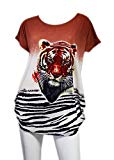

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 1.4353025921862632
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


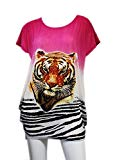

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 11.592534324701543
Amazon Url: www.amzon.com/dp/B00JXQASS6


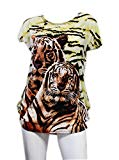

Product Title:  yellow tiger tshirt tiger stripes  l 
Euclidean Distance from input image: 15.1114955448689
Amazon Url: www.amzon.com/dp/B00JXQCUIC


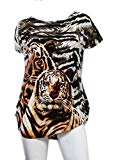

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean Distance from input image: 16.04373675637552
Amazon Url: www.amzon.com/dp/B00JXQCWTO


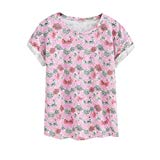

Product Title:  kawaii pastel tops tees pink flower design 
Euclidean Distance from input image: 17.26716348033147
Amazon Url: www.amzon.com/dp/B071FCWD97


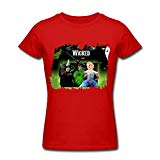

Product Title:  womans wicked musical poster shirts red xxl 
Euclidean Distance from input image: 17.30506859671857
Amazon Url: www.amzon.com/dp/B01KUN4VWE


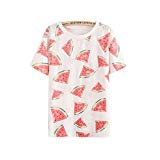

Product Title:  womens thin style tops tees pastel watermelon print 
Euclidean Distance from input image: 17.336361676853404
Amazon Url: www.amzon.com/dp/B01JUNHBRM


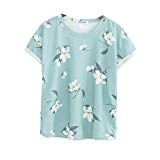

Product Title:  kawaii pastel tops tees baby blue flower design 
Euclidean Distance from input image: 17.364336039567828
Amazon Url: www.amzon.com/dp/B071SBCY9W


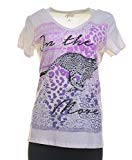

Product Title:  edv cheetah run purple multi xl 
Euclidean Distance from input image: 17.447705681828772
Amazon Url: www.amzon.com/dp/B01CUPYBM0


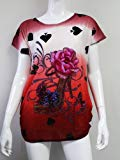

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Euclidean Distance from input image: 17.49346421381039
Amazon Url: www.amzon.com/dp/B00JV63QQE


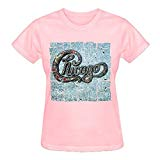

Product Title:  chicago chicago 18 shirt women pink 
Euclidean Distance from input image: 17.51841866485773
Amazon Url: www.amzon.com/dp/B01GXAZTRY


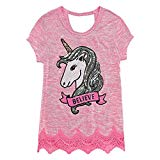

Product Title:  miss chievous juniors striped peplum tank top medium shadowpeach 
Euclidean Distance from input image: 17.530549725272706
Amazon Url: www.amzon.com/dp/B0177DM70S


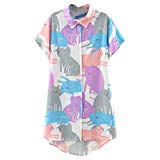

Product Title:  abaday multicolor cartoon cat print short sleeve longline shirt large 
Euclidean Distance from input image: 17.531649027659764
Amazon Url: www.amzon.com/dp/B01CR57YY0


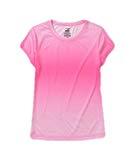

Product Title:  danskin womens vneck loose performance tee xsmall pink ombre 
Euclidean Distance from input image: 17.54252242536661
Amazon Url: www.amzon.com/dp/B01F7PHXY8


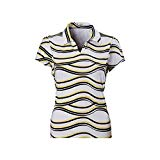

Product Title:  nancy lopez whimsy short sleeve  whiteblacklemon drop  xs 
Euclidean Distance from input image: 17.554174096102475
Amazon Url: www.amzon.com/dp/B01MPX6IDX


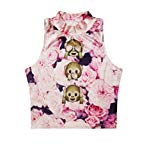

Product Title:  kingde star pink flower dog stamp sleeveless vestbqn24 
Euclidean Distance from input image: 17.56964761076337
Amazon Url: www.amzon.com/dp/B015H3W9BM


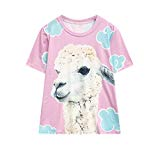

Product Title:  summer alpaca 3d pastel casual loose tops tee design 
Euclidean Distance from input image: 17.575388976980197
Amazon Url: www.amzon.com/dp/B01I80A93G


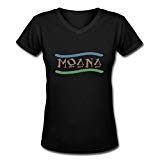

Product Title:  moana logo adults hot v neck shirt black xxl 
Euclidean Distance from input image: 17.58003070013558
Amazon Url: www.amzon.com/dp/B01LX6H43D


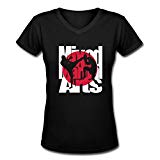

Product Title:  women japanese mixed martial arts teeblack tshirts hgiorgis xxl black 
Euclidean Distance from input image: 17.5813816269737
Amazon Url: www.amzon.com/dp/B01JQ096HW


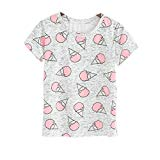

Product Title:  womens tops tees pastel peach ice cream cone print 
Euclidean Distance from input image: 17.594947768505442
Amazon Url: www.amzon.com/dp/B0734GRKZL


In [28]:
# title vector weight = 5
# brand and color weight = 5 
# image weight = 5
tf_idf_w2v_brand_img(12566, 5, 5,5, 20)

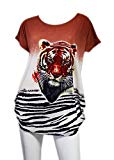

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 2.4801459916062085
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


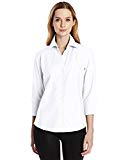

Product Title:  foxcroft nyc womens pinpoint oxford shirt noniron stretch poplin blouse xlarge white 
Euclidean Distance from input image: 4.921850079794725
Amazon Url: www.amzon.com/dp/B072277HVB


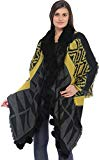

Product Title:  exotic india yellow gray jamawar wrap fauxfur collar 
Euclidean Distance from input image: 5.036454172887278
Amazon Url: www.amzon.com/dp/B073ZHRBV8


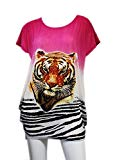

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 5.385602173941936
Amazon Url: www.amzon.com/dp/B00JXQASS6


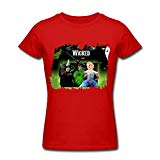

Product Title:  womans wicked musical poster shirts red xxl 
Euclidean Distance from input image: 5.3869273209594635
Amazon Url: www.amzon.com/dp/B01KUN4VWE


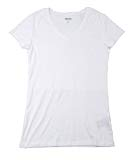

Product Title:  kirkland signature ladies size medium cotton vneck tee white 
Euclidean Distance from input image: 5.749541287304846
Amazon Url: www.amzon.com/dp/B073ZRD5FL


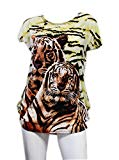

Product Title:  yellow tiger tshirt tiger stripes  l 
Euclidean Distance from input image: 5.762187369515669
Amazon Url: www.amzon.com/dp/B00JXQCUIC


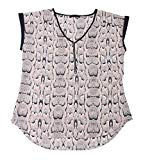

Product Title:  fylo ladies size medium 14 zip vneck blouse pinkgrey animal 
Euclidean Distance from input image: 5.905185162349216
Amazon Url: www.amzon.com/dp/B073X71H8K


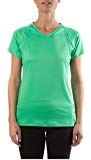

Product Title:  kirkland signature ladies striped active yoga tee large green 
Euclidean Distance from input image: 5.923992217223328
Amazon Url: www.amzon.com/dp/B01LXO8SGX


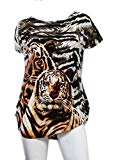

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean Distance from input image: 5.995247672392323
Amazon Url: www.amzon.com/dp/B00JXQCWTO


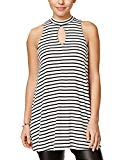

Product Title:  material girl womens juniors cutout swing shift caviar black combo xxl 
Euclidean Distance from input image: 5.997348736377789
Amazon Url: www.amzon.com/dp/B072L5CGR3


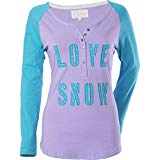

Product Title:  divas love snow henley long sleeve tshirt 4xlarge violetturquoise 
Euclidean Distance from input image: 6.075178156337292
Amazon Url: www.amzon.com/dp/B071NHMRB2


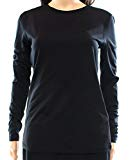

Product Title:  ideology womens small crewneck solid tee tshirt black 
Euclidean Distance from input image: 6.122206802923378
Amazon Url: www.amzon.com/dp/B0721T22DL


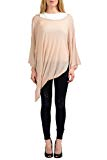

Product Title:  maison margiela mm6 beige 34 sleeve womens blouse top us 42 
Euclidean Distance from input image: 6.126493593634649
Amazon Url: www.amzon.com/dp/B01N7OM7H4


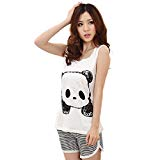

Product Title:  blouseuploter cute cartoon vest summer pajamas 
Euclidean Distance from input image: 6.161224583812348
Amazon Url: www.amzon.com/dp/B01LPJRYI0


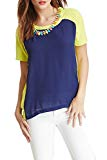

Product Title:  romeo  juliet navy womens medium jeweled knit top green 
Euclidean Distance from input image: 6.1647342745005
Amazon Url: www.amzon.com/dp/B071P49MCK


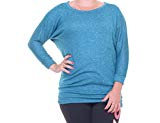

Product Title:  hippie rose juniors marled dolmansleeve tunic top size 
Euclidean Distance from input image: 6.226199015562485
Amazon Url: www.amzon.com/dp/B072HXX3W7


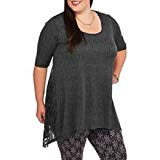

Product Title:  miss chievous womens short sleeve knit top wsharkbite hem charcoal 1x 
Euclidean Distance from input image: 6.237818929329312
Amazon Url: www.amzon.com/dp/B06XR9NTVL


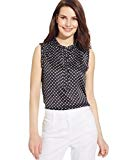

Product Title:  tahari asl ruffledfront polkadot top blackwhite xl 
Euclidean Distance from input image: 6.238325011986584
Amazon Url: www.amzon.com/dp/B074MZTZS5


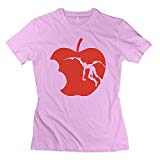

Product Title:  hnan womens death note ryuk silhouette oneck tshirt pink xl 
Euclidean Distance from input image: 6.266822157200525
Amazon Url: www.amzon.com/dp/B011I80ET4


In [29]:
# title vector weight = 5
# brand and color weight = 50 
# image weight = 5
idf_w2v_brand(12566, 5, 50, 5, 20)

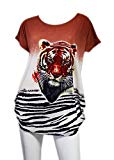

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 1.4341505269368173
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


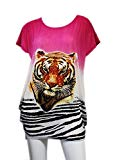

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 5.774470854648433
Amazon Url: www.amzon.com/dp/B00JXQASS6


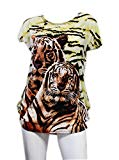

Product Title:  yellow tiger tshirt tiger stripes  l 
Euclidean Distance from input image: 7.29214030399913
Amazon Url: www.amzon.com/dp/B00JXQCUIC


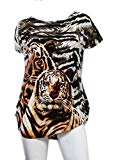

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean Distance from input image: 7.7246075206204585
Amazon Url: www.amzon.com/dp/B00JXQCWTO


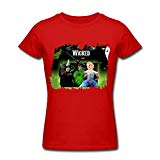

Product Title:  womans wicked musical poster shirts red xxl 
Euclidean Distance from input image: 8.20674314929088
Amazon Url: www.amzon.com/dp/B01KUN4VWE


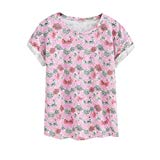

Product Title:  kawaii pastel tops tees pink flower design 
Euclidean Distance from input image: 8.211058671580824
Amazon Url: www.amzon.com/dp/B071FCWD97


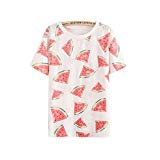

Product Title:  womens thin style tops tees pastel watermelon print 
Euclidean Distance from input image: 8.265451011929114
Amazon Url: www.amzon.com/dp/B01JUNHBRM


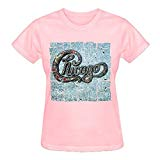

Product Title:  chicago chicago 18 shirt women pink 
Euclidean Distance from input image: 8.275425249616955
Amazon Url: www.amzon.com/dp/B01GXAZTRY


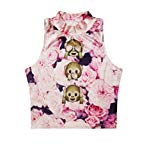

Product Title:  kingde star pink flower dog stamp sleeveless vestbqn24 
Euclidean Distance from input image: 8.32401854508995
Amazon Url: www.amzon.com/dp/B015H3W9BM


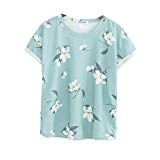

Product Title:  kawaii pastel tops tees baby blue flower design 
Euclidean Distance from input image: 8.324805273108431
Amazon Url: www.amzon.com/dp/B071SBCY9W


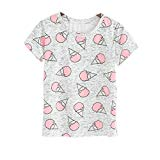

Product Title:  womens tops tees pastel peach ice cream cone print 
Euclidean Distance from input image: 8.339796347835268
Amazon Url: www.amzon.com/dp/B0734GRKZL


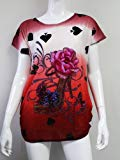

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Euclidean Distance from input image: 8.344351328287834
Amazon Url: www.amzon.com/dp/B00JV63QQE


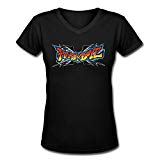

Product Title:  cling womens hardy boyz wwe logo vneck tshirt black 
Euclidean Distance from input image: 8.345894662682676
Amazon Url: www.amzon.com/dp/B01A82FFBI


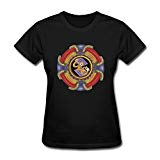

Product Title:  dasy womens neck electric light orchestra logo shirt xxlarge black 
Euclidean Distance from input image: 8.366595373713558
Amazon Url: www.amzon.com/dp/B016EXUZC4


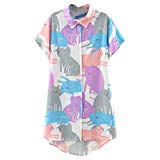

Product Title:  abaday multicolor cartoon cat print short sleeve longline shirt large 
Euclidean Distance from input image: 8.371207667674895
Amazon Url: www.amzon.com/dp/B01CR57YY0


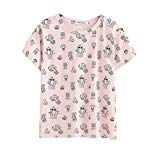

Product Title:  kawaii cotton pastel tops tees peach pink cactus design 
Euclidean Distance from input image: 8.37219009148908
Amazon Url: www.amzon.com/dp/B071WYLBZS


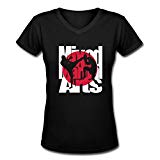

Product Title:  women japanese mixed martial arts teeblack tshirts hgiorgis xxl black 
Euclidean Distance from input image: 8.37726345147816
Amazon Url: www.amzon.com/dp/B01JQ096HW


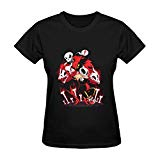

Product Title:  underfell skele bros womens diy customize tshirtblack xlargeblackxlargeblack 
Euclidean Distance from input image: 8.383611957722426
Amazon Url: www.amzon.com/dp/B06X6KCJ6Z


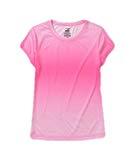

Product Title:  danskin womens vneck loose performance tee xsmall pink ombre 
Euclidean Distance from input image: 8.390048751901661
Amazon Url: www.amzon.com/dp/B01F7PHXY8


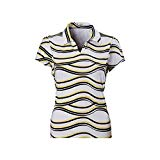

Product Title:  nancy lopez whimsy short sleeve  whiteblacklemon drop  xs 
Euclidean Distance from input image: 8.402004289343392
Amazon Url: www.amzon.com/dp/B01MPX6IDX


In [30]:
# title vector weight = 50
# brand and color weight = 10 
# image weight = 10

idf_w2v_brand(12566, 50, 10, 10, 20)

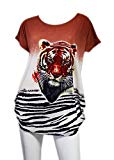

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 0.8382492210891515
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


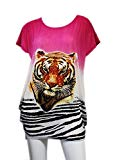

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 15.139353277851377
Amazon Url: www.amzon.com/dp/B00JXQASS6


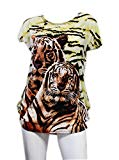

Product Title:  yellow tiger tshirt tiger stripes  l 
Euclidean Distance from input image: 20.453958231287267
Amazon Url: www.amzon.com/dp/B00JXQCUIC


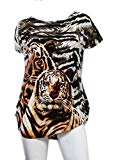

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean Distance from input image: 21.785731390582438
Amazon Url: www.amzon.com/dp/B00JXQCWTO


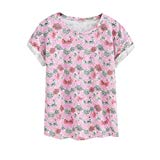

Product Title:  kawaii pastel tops tees pink flower design 
Euclidean Distance from input image: 23.38166182411564
Amazon Url: www.amzon.com/dp/B071FCWD97


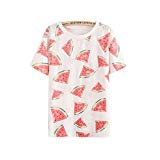

Product Title:  womens thin style tops tees pastel watermelon print 
Euclidean Distance from input image: 23.55404965733239
Amazon Url: www.amzon.com/dp/B01JUNHBRM


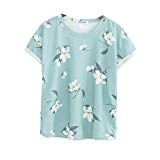

Product Title:  kawaii pastel tops tees baby blue flower design 
Euclidean Distance from input image: 23.67230092321207
Amazon Url: www.amzon.com/dp/B071SBCY9W


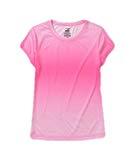

Product Title:  danskin womens vneck loose performance tee xsmall pink ombre 
Euclidean Distance from input image: 23.775032617525216
Amazon Url: www.amzon.com/dp/B01F7PHXY8


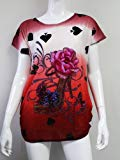

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Euclidean Distance from input image: 23.77847981848002
Amazon Url: www.amzon.com/dp/B00JV63QQE


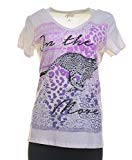

Product Title:  edv cheetah run purple multi xl 
Euclidean Distance from input image: 23.791399830869075
Amazon Url: www.amzon.com/dp/B01CUPYBM0


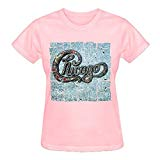

Product Title:  chicago chicago 18 shirt women pink 
Euclidean Distance from input image: 23.81412874361833
Amazon Url: www.amzon.com/dp/B01GXAZTRY


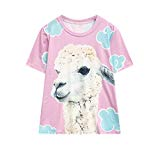

Product Title:  summer alpaca 3d pastel casual loose tops tee design 
Euclidean Distance from input image: 23.82198425282885
Amazon Url: www.amzon.com/dp/B01I80A93G


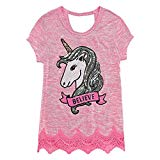

Product Title:  miss chievous juniors striped peplum tank top medium shadowpeach 
Euclidean Distance from input image: 23.83145882992544
Amazon Url: www.amzon.com/dp/B0177DM70S


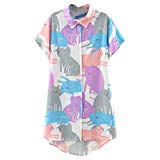

Product Title:  abaday multicolor cartoon cat print short sleeve longline shirt large 
Euclidean Distance from input image: 23.83303042448136
Amazon Url: www.amzon.com/dp/B01CR57YY0


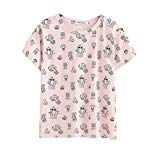

Product Title:  kawaii cotton pastel tops tees peach pink cactus design 
Euclidean Distance from input image: 23.86244412209763
Amazon Url: www.amzon.com/dp/B071WYLBZS


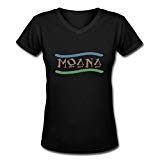

Product Title:  moana logo adults hot v neck shirt black xxl 
Euclidean Distance from input image: 23.902146227516006
Amazon Url: www.amzon.com/dp/B01LX6H43D


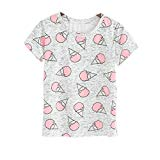

Product Title:  womens tops tees pastel peach ice cream cone print 
Euclidean Distance from input image: 23.923456615830837
Amazon Url: www.amzon.com/dp/B0734GRKZL


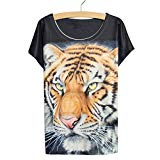

Product Title:  yichun womens tiger printed summer tshirts tops 
Euclidean Distance from input image: 23.942228697416787
Amazon Url: www.amzon.com/dp/B010NN9RXO


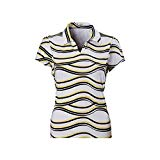

Product Title:  nancy lopez whimsy short sleeve  whiteblacklemon drop  xs 
Euclidean Distance from input image: 23.94349698425859
Amazon Url: www.amzon.com/dp/B01MPX6IDX


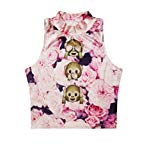

Product Title:  kingde star pink flower dog stamp sleeveless vestbqn24 
Euclidean Distance from input image: 23.96560258648993
Amazon Url: www.amzon.com/dp/B015H3W9BM


In [33]:
# title vector weight = 50
# brand and color weight = 5 
# image weight = 50

idf_w2v_brand(12566, 50, 5, 50, 20)

## Procedure followed

1. Exploratory data anlysis <br>
	1.1 explore different columns<br>
	1.2 Remove near duplicate items
		- remove item which have very short title. 
		- remove items which are different only at the end.
		- remove items which are not adjacent but similar.
2. Text preprocessing
	- remove special characters and stop words
	- perform stemming
3. Prepare features
	- Create tfidf features of title
	- Prepare features for brand, colour and type
	- Generate features for images using CNN
4. Find most similar apparels using euclidean distance